In [60]:
import gudhi as gd

from ripser import ripser
import persim
import numpy as np
import matplotlib.pyplot as plt

from gudhi.wasserstein import wasserstein_distance
from sklearn import manifold

In [68]:
fs = 14
colors = ['coral','dodgerblue']
markers =  ['s', 'D']
legend_kw = dict(facecolor='gainsboro', framealpha=1, borderpad=0)

In [2]:
M,N = 100,5
rng = np.random.default_rng(42)
dgms = [None for _ in range(2*N)]

data = rng.uniform(size=(N*M,2))
for i in range(0,len(data),M):
    diags = ripser(data[i:i+M])
    dgms[i//M] = [ diags['dgms'][hdim][ np.all(diags['dgms'][hdim] < np.inf, axis = 1) ] for hdim in range(len(diags['dgms'])) ]

data = rng.normal(size=(N*M,2))
for i in range(0,len(data),M):
    diags = ripser(data[i:i+M])
    dgms[N + i//M] = [ diags['dgms'][hdim][ np.all(diags['dgms'][hdim] < np.inf, axis = 1) ] for hdim in range(len(diags['dgms'])) ]

maxval = max([max(map(np.max, dgm)) for dgm in dgms ])

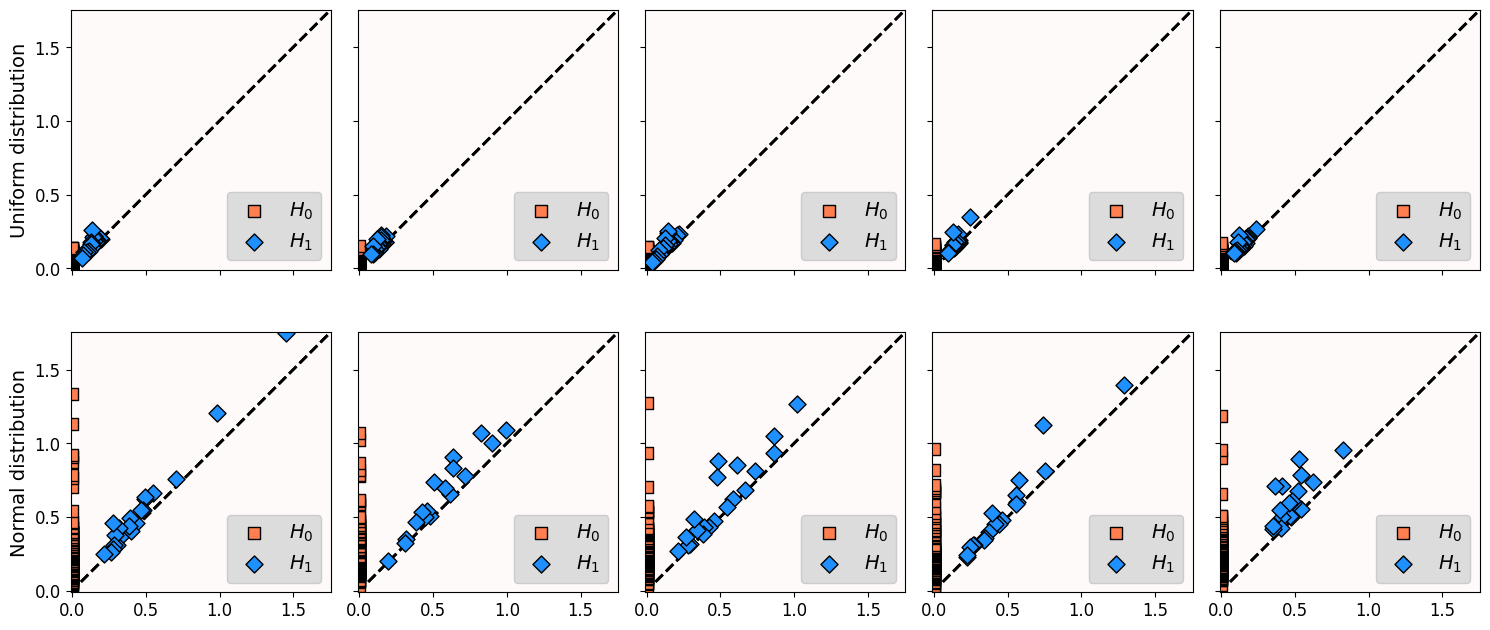

In [3]:
fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    for j in range(len(dgms[i])):
        ax[i].axline((0,0), slope=1, ls='dashed', lw=2, zorder=1, c='k')
        ax[i].scatter(*dgms[i][j].T, s=75, fc=colors[j], ec='k', marker=markers[j], label='$H_{{{}}}$'.format(j), zorder=2)
        ax[i].legend(loc='lower right', fontsize=fs, **legend_kw)

    # Make the plots prettier
    ax[i].set_facecolor('snow')
    ax[i].set_xlim(-0.01, maxval+0.01)
    ax[i].set_ylim(-0.01, maxval+0.01)
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelsize=.85*fs)

ax[0].set_ylabel('Uniform distribution', fontsize=fs)
ax[N].set_ylabel('Normal distribution', fontsize=fs)
fig.tight_layout()

# Only consider $H_1$

In [ ]:
hdim = 1

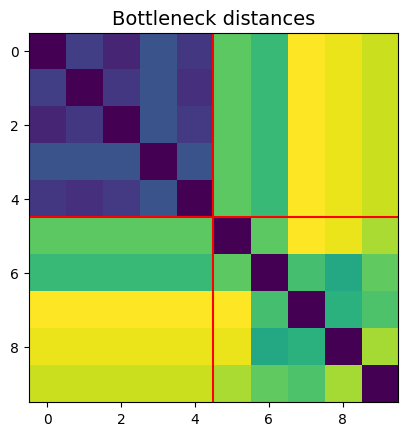

In [10]:
bns = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        bn = gd.bottleneck_distance(dgms[i][hdim], dgms[j][hdim])
        bns[i,j] = bn
        bns[j,i] = bn
plt.imshow(bns);
plt.axvline(N-.5, c='r')
plt.axhline(N-.5, c='r')
plt.title('Bottleneck distances', fontsize=fs);

In [62]:
mds_params = dict(n_components=2, max_iter=3000,  eps=1e-9, n_init=1, random_state=42, dissimilarity="precomputed", n_jobs=1)
mds = manifold.MDS(**mds_params)
X_mds = mds.fit(bns).embedding_

{'n_components': 2,
 'max_iter': 3000,
 'eps': 1e-09,
 'n_init': 1,
 'random_state': 42,
 'dissimilarity': 'precomputed',
 'n_jobs': 1}

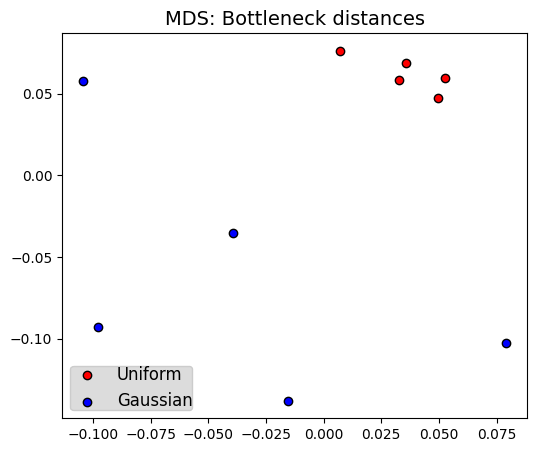

In [71]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax.scatter(*X_mds[5:].T, fc='b', ec='k', marker='o', label='Gaussian')
ax.legend(fontsize=0.85*fs, **legend_kw)
ax.set_title('MDS: Bottleneck distances', fontsize=fs);

If gudhi's version does not work for you, try using persim's: `persim.wasserstein` ([doc](https://persim.scikit-tda.org/en/latest/reference/stubs/persim.wasserstein.html#persim.wasserstein))

Text(0.5, 1.0, 'Wasserstein distances')

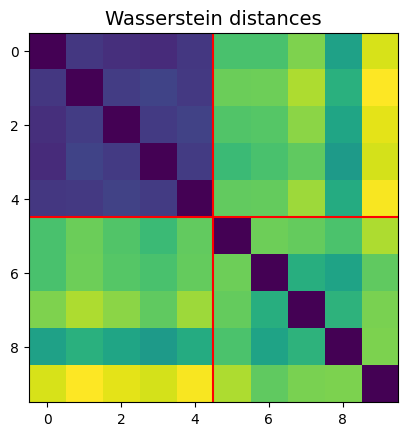

In [9]:
wds = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        wd = wasserstein_distance(dgms[i][hdim], dgms[j][hdim])
        wds[i,j] = wd
        wds[j,i] = wd
plt.imshow(wds);
plt.axvline(N-.5, c='r')
plt.axhline(N-.5, c='r')
plt.title('Wasserstein distances', fontsize=fs);

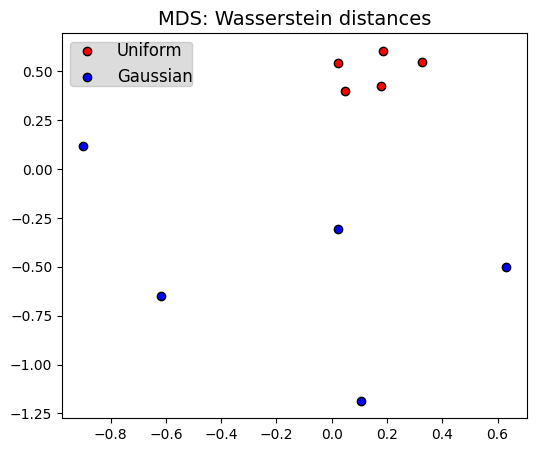

In [72]:
mds = manifold.MDS(**mds_params)
X_mds = mds.fit(wds).embedding_

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax.scatter(*X_mds[5:].T, fc='b', ec='k', marker='o', label='Gaussian')
ax.legend(fontsize=0.85*fs, **legend_kw);
ax.set_title('MDS: Wasserstein distances', fontsize=fs);

In [23]:
lt_h1 = [ np.column_stack((dgm[hdim][:,0], dgm[hdim][:,1]-dgm[hdim][:,0])) for dgm in dgms ]
lt_all = np.vstack(lt_h1)
max_birth, max_lt = np.max(lt_all, axis=0)
print(max_birth, max_lt, sep='\t')

1.4483269453048706	0.39502033591270447


In [41]:
sigma = 0.25
persw = 1
pixsz = 0.15

pi_params = {'birth_range':(0, pixsz * np.ceil((max_birth + sigma)/pixsz)),
             'pers_range':(0, pixsz * np.ceil((max_lt + sigma)/pixsz)),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': persw},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }

pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ])
print(extent)

[0.   1.8  0.   0.75]


In [52]:
pimgs = np.asarray(pimgr.transform(lt_h1, skew=False))
pi_vmax = np.max(pimgs)
print(pimgs.shape)

(10, 12, 5)


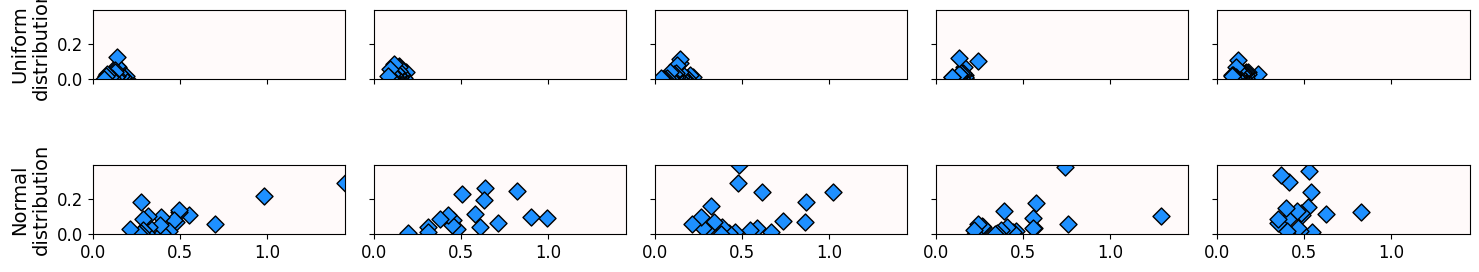

In [51]:
fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].scatter(*lt_h1[i].T, s=75, fc=colors[hdim], ec='k', marker=markers[hdim], label='$H_{{{}}}$'.format(hdim), zorder=2)
    #ax[i].legend(loc='upper right', fontsize=0.85*fs, facecolor='gainsboro', framealpha=1, borderpad=0)

    ax[i].set_facecolor('snow')
    ax[i].set_xlim(0, max_birth)
    ax[i].set_ylim(0, max_lt)
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelsize=.85*fs)

ax[0].set_ylabel('Uniform\ndistribution', fontsize=fs)
ax[N].set_ylabel('Normal\ndistribution', fontsize=fs)
fig.tight_layout()

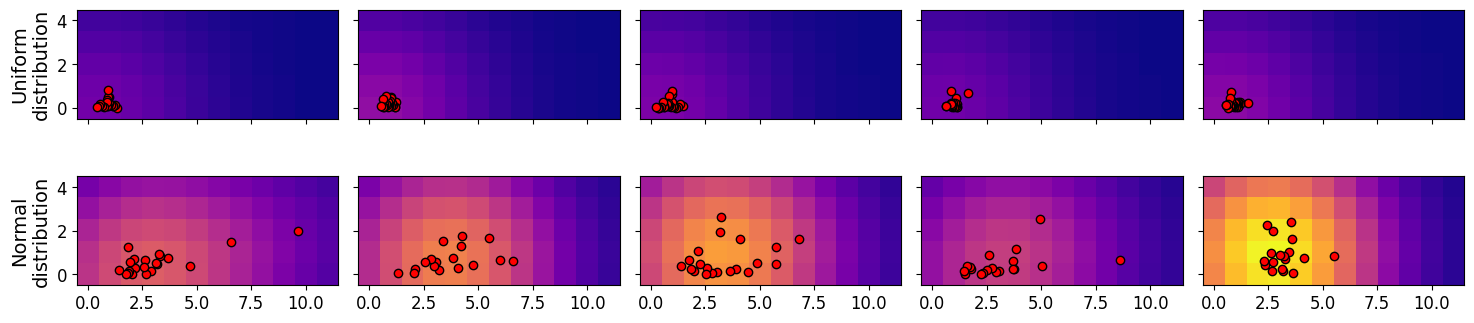

In [59]:
fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].imshow(pimgs[i].T, origin='lower', cmap='plasma', vmin=0, vmax=pi_vmax)
    ax[i].scatter(*(lt_h1[i].T)/pixsz, marker='o', fc='r', ec='k', zorder=2)
    #ax[i].legend(loc='upper right', fontsize=0.85*fs, facecolor='gainsboro', framealpha=1, borderpad=0)

    ax[i].tick_params(labelsize=.85*fs)

ax[0].set_ylabel('Uniform\ndistribution', fontsize=fs)
ax[N].set_ylabel('Normal\ndistribution', fontsize=fs)
fig.tight_layout()

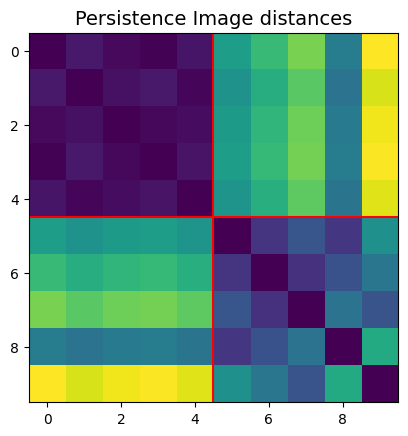

In [80]:
pids = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        pid = np.sqrt(np.sum((pimgs[j] - pimgs[i])**2))
        pids[i,j] = pid
        pids[j,i] = pid
plt.imshow(pids);
plt.axvline(N-.5, c='r')
plt.axhline(N-.5, c='r')
plt.title('Persistence Image distances', fontsize=fs);

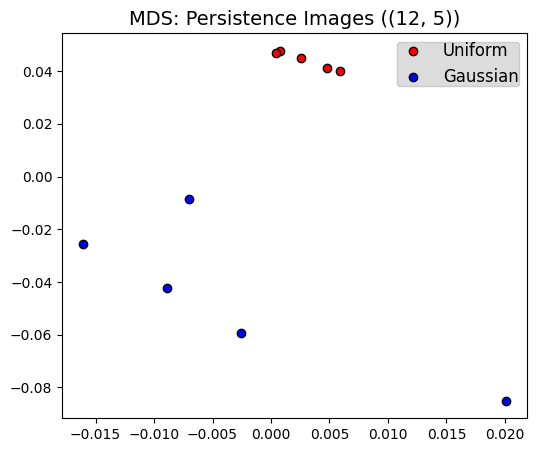

In [81]:
mds = manifold.MDS(**mds_params)
X_mds = mds.fit(pids).embedding_

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax.scatter(*X_mds[5:].T, fc='b', ec='k', marker='o', label='Gaussian')
ax.legend(fontsize=0.85*fs, **legend_kw);
ax.set_title('MDS: Persistence Images ({})'.format(pimgs.shape[1:]), fontsize=fs);